# Generalizing the State Space

Here we'll look at a more complex environment, and ways that an agent can remember the actions it took in different states and the results of those actions.

In [1]:
import gym
env = gym.make('Acrobot-v1')
observation = env.reset()
env.render()

True

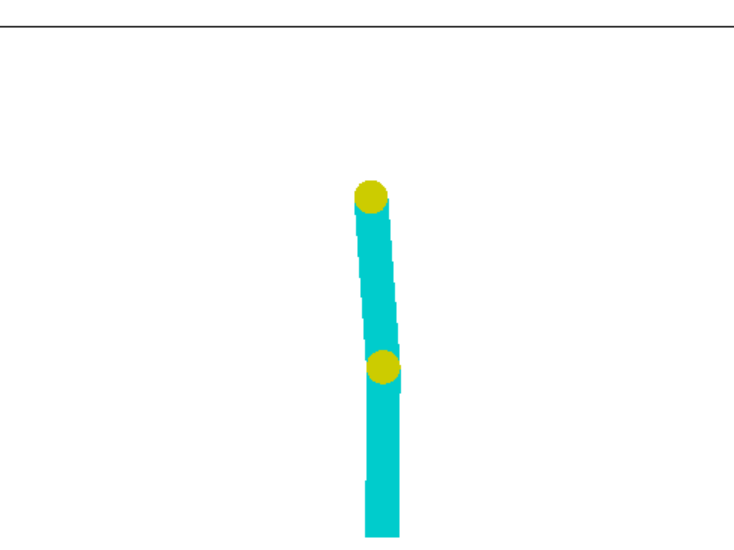


In [2]:
env.close()

In this environment we've got an arm with joints on it, and the objective is to keep it up above the line.  Gravity is pulling down on the arm, and there's momentum.  There's an actuator on the middle joint, so to make this thing work we'll have to do some swinging.

In [13]:
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Box(6,)
[ 1.        1.        1.        1.       12.566371 28.274334]
[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]


The state of the environment is expressed as an array of 6 numbers, the first 4 of which vary from -1 to +1.

Let's look at the action space.

In [4]:
print(env.action_space)

Discrete(3)


The Discrete(3) means there are only 3 possible actions we can take at each step.

In [5]:
[env.action_space.sample() for i in range(10)]

[0, 1, 2, 2, 2, 2, 1, 1, 0, 1]

Let's see what this system does. First, we'll just take action 0 and see what happens.  Then we'll try other actions.

In [207]:
env = gym.make('Acrobot-v1')
observation = env.reset()
for i in range(300):
    action = 2 # Try all the values from 0 to 2 and see what happens.
    observation, reward, done, info = env.step(action)
    env.render()
    if done:
        break
env.close()

Not much changes if we always take the same action.  Let's try some random actions, and see what kinds of ranges of values we're seeing in the observations.

In [209]:
observations = []
rewards = []
env = gym.make('Acrobot-v1')
observation = env.reset()
for i in range(500):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    observations.append(observation)
    rewards.append(reward)
    env.render()
    if done:
        break
env.close()

Let's take a look at the ranges of values in the observations.  Let's start with a histogram of the values of the first observation bucket.

In [56]:
obs0 = [x[0] for x in observations]

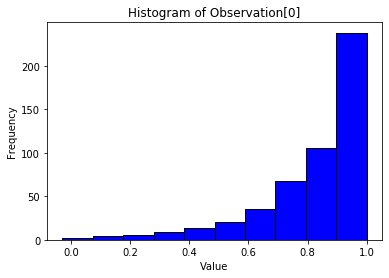

In [57]:
import matplotlib.pyplot as plt

plt.hist(obs0, color = 'blue', edgecolor = 'black', bins = 10)
plt.title('Histogram of Observation[0]')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

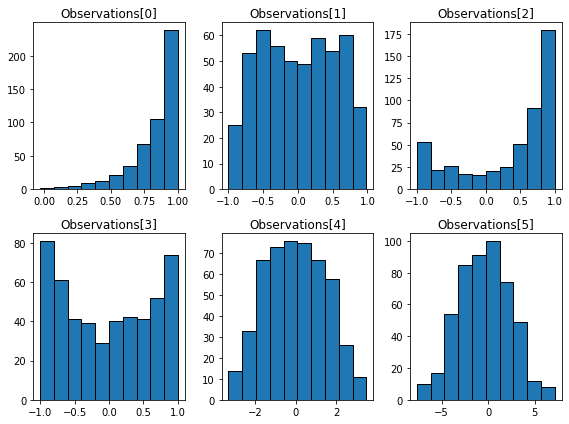

In [58]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8,6))

elementCount = env.observation_space.shape[0] # How many elements are in a state observation (6).
for i in range(elementCount):
    ax = plt.subplot(2, 3, i + 1)
    obs = [x[i] for x in observations]
    ax.hist(obs, edgecolor='black', bins = 10)
    ax.set_title('Observations[%s]' % i)

plt.tight_layout()
plt.show()

Let's look at the values we've been getting for the rewards:

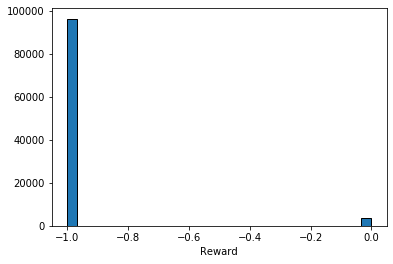

In [179]:
def plot_rewards(rewards):
    plt.hist(rewards, edgecolor='black', bins=30)
    plt.xlabel('Reward')
    plt.show()

plot_rewards(rewards)

So we never saw any positive rewards.

In [60]:
[x for x in rewards if x != -1]

[]

Let's run this randomly for much longer and see if we can get any positive rewards.  We'll turn off rendering so it can run faster, and take out the "done" check that makes it stop after 500 iterations.

In [61]:
rewards = []
env = gym.make('Acrobot-v1')
observation = env.reset()
for i in range(100000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    # env.render()
    #if done:
    #    break

pos_rewards = [x for x in rewards if x != -1]
print('%s steps, unusual rewards=%s' % (len(rewards), len(pos_rewards)))

100000 steps, unusual rewards=3747


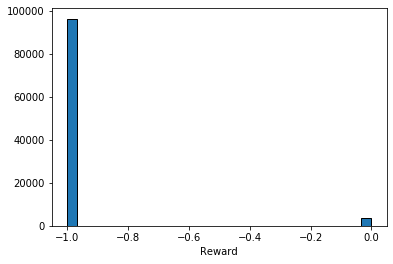

In [62]:
plot_rewards(rewards)

# Building some intelligence
Let's try building a primitive learning agent that figures out how to get at those rare higher rewards.  It's kind of sad that the best we can hope for is a zero reward instead of a negative award.  I suppose that's more like pain avoidance than reward seeking.

The general strategy we're going to try here is to bucket the observations into buckets based on all 6 terms that we observe, bucketing each one into a range of values.  Then whenever we see a good reward, go back to the several actions before that and give that action a positive boost.

So we need to do a couple of things.

  1. **Generalizing observations**: Bucket observations into bins.  Later we will do this with neural nets, but for now we'll do it with simple buckets.
  2. **Tracking rewards**.  When we see improved rewards, backtrack onto the actions we took in previous steps and mark those as having lead to good results.

## Generalizing Observations
The first step is to make some kind of data structure to hold our observations in a generalized way.  It won't do us much good to use a straight hashtable for all 6 of the values, because we want things that are similar to be grouped together.  We'll probably never see the exact same set of 6 values twice, so we want something that'll find things that are in similar *neighborhoods*.


### Discretizer
We'll start by making a *Discretizer* that bins a given value in a way similar to the histograms did above.  Then we'll use 6 of those discretizers in combination to generalize our state space.  Let's work out the mechanics for our Discretizer.

In [66]:
lo, hi = env.observation_space.low[0], env.observation_space.high[0]
lo,hi

(-1.0, 1.0)

In [92]:
bins = 10
val = 0.2 # our example value
value_range = hi - lo
value_range

2.0

In [93]:
val - lo  # This is how far above the minimum value our value is

1.2

In [97]:
(val - lo) / value_range  # This is the fraction along the possible spectrum of values this value is.

0.6

We're going to make *bins* number of bins where each bin represents one segment of the range of values.

In [96]:
bin_width = value_range / bins
bin_width

0.2

In [99]:
(val-lo) / bin_width

5.999999999999999

So that's saying our example value of 0.2 should be in bin 5 or 6.  Let's cement that into a formula and try several values and see if it looks like it's doing what we want.

In [101]:
def choose_bin(val):
    return (val - lo) / bin_width

[choose_bin(x) for x in [-1, -0.95, -0.78, -0.3, 0.3, 0.65, 0.9, 1]]

[0.0,
 0.2500000000000002,
 1.0999999999999999,
 3.4999999999999996,
 6.5,
 8.249999999999998,
 9.499999999999998,
 10.0]

That looks like approximately what we want to do. It looks like we should take the integer value for the bin, chopping off the fractional part.  We're now ready to build our discretizer:

In [116]:
class Discretizer:
    """Discretizes or 'bins' a continuous variable into one of several buckets."""
    
    def __init__(self, low_value, high_value, buckets):
        self.low_value = low_value
        self.bin_width = (high_value - low_value) / buckets

    def bin(self, value):
        return int((value - self.low_value) / self.bin_width)

In [118]:
d = Discretizer(-1, 1, 10)
[d.bin(x) for x in [-1, -0.95, -0.78, -0.3, 0.3, 0.65, 0.9, 0.99999]]

[0, 0, 1, 3, 6, 8, 9, 9]

Notice how our discretizer lumped the first two values together, and the last two values together.  That's the kind of generalization we're looking for in this simple exercise.  This will allow similar state values to be treated the same.  Note that what we're building here is going to be fairly primitive because it's lumpy instead of smooth-- it'd be better if we were doing techniques like regression that would estimate our values *continuously* and interpolate rather than just simple binning.  But we're going to start simple and build up to that.

### StateGeneralizer
Now we have a *Discretizer* that can generalize a single variable.  Let's build a *StateGeneralizer* that can generalize an entire objservation that is comprised of *n* number of components.  In our case, our observations have 6 different continuous components.

For its input it can take a list of low values and a list of high values from the environments observation_space.  It will then build a *Discretizer* for each of the components of the observation space.

In [149]:
class StateGeneralizer:
    """Categorizes or 'bins' a state that is comprised of several continuous variables."""
    
    def __init__(self, low_values, high_values, buckets):
        """low_values and high_values are lists of the same length describing the range
        of each component in the state.
        buckets is the number of bins that are used to bin the states.
        """
        self.discretizers = [Discretizer(low_values[i], high_values[i], buckets) for i in range(len(low_values))]

    def bin(self, state):
        """
        state is an array of values that together describe a single state.
        Returns the binned representation of this state, which you can use for generalization.
        """
        return tuple([self.discretizers[i].bin(state[i]) for i in range(len(state))])

In [167]:
generalizer = StateGeneralizer(env.observation_space.low, env.observation_space.high, 10)

In [168]:
generalizer.discretizers

In [169]:
generalizer.discretizers[0].bin_width, s.discretizers[0].low_value

(0.2, -1.0)

It's built our discretizers and they look good.  Let's try it.  We've got an observation lying around from earlier.  Let's see if it generalizes.

In [154]:
observation

array([ 0.95054708, -0.3105805 ,  0.97690753, -0.21366252,  0.81582252,
        1.85959618])

In [170]:
generalizer.bin(observation)

(9, 3, 9, 3, 5, 5)

We've got a whole pile of observations from earlier. Let's try a few of them.

In [156]:
len(observations)


500

In [171]:
for i in [12, 30, 128, 400, 401, 403, 404, 480]:
    print(generalizer.bin(observations[i]))

(9, 4, 9, 2, 4, 5)
(9, 5, 8, 1, 5, 4)
(9, 7, 7, 0, 4, 5)
(6, 9, 9, 6, 5, 4)
(5, 9, 9, 5, 4, 4)
(8, 8, 9, 7, 4, 5)
(9, 6, 8, 8, 3, 5)
(7, 9, 9, 4, 5, 4)


It does look like it's generalizing.  Several of those values look close to each other.  Let's see how many distinct values we have.  We'll do that by building a dictionary using the list as the key.

In [172]:
k = generalizer.bin(observation)
k

(9, 3, 9, 3, 5, 5)

The StateGeneralizer returns a *tuple* for its value instead of a list.  That's because we can't use a list as a dictionary key, but you can use a tuple.  Mostly the reason for this is that lists are mutable.  So if we put a value into the dictionary on list x, then append a value onto list x, what should happen to the original key?  Let's try using a list as a dictionary key.

In [160]:
d = {}
key = [1,2,3]
d[key] = 99

TypeError: unhashable type: 'list'

But we can use that tuple we made earlier as a dictionary key:

In [162]:
print(k)
print(type(k))

(9, 3, 9, 3, 5, 5)
<class 'tuple'>


In [165]:
d[k] = 99
d

{(9, 3, 9, 3, 5, 5): 99}

### Checking out our state generalization
Let's try out our state generalizer.  Let's run a few thousand iterations and gather a few statistics:
  1. How many distinct states do we see
  2. How many states received positive values
  3. How often we were in each of those states

In [216]:
class StateStat:
    """Holds statistics about each state."""
    def __init__(self):
        self.visit_count = 0
        self.positive_rewards = 0

In [199]:
from collections import defaultdict

bin_count = 10 # Discretize each component of state into this many bins.
stats = defaultdict(StateStat) # When we access a key that's not found, creates a StateStat there.
generalizer = StateGeneralizer(env.observation_space.low, env.observation_space.high, bin_count)

env.reset()
for i in range(100000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    key = generalizer.bin(observation)
    stats[key].visit_count += 1
    if reward != 0:
        stats[key].positive_rewards += 1

Let's take a look at our gathered statistics.  First let's answer question 1 above.

In [200]:
len(stats)

9461

Out of 100,000 iterations, we got into unique situations according to our bucketing strategy about 1 in 10 times.

Let's check the density of how often we visited each of those states.

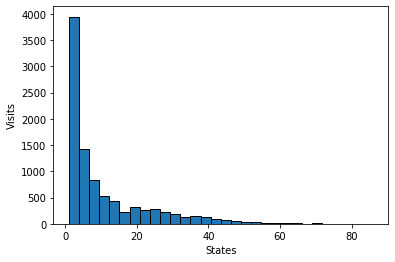

In [201]:
plt.hist([s.visit_count for s in stats.values()], edgecolor='black', bins=30)
plt.xlabel('States')
plt.ylabel('Visits')
plt.show()


How many of our recorded states resulted in improved rewards?

In [202]:
len([s for s in stats.values() if s.positive_rewards > 0])

8547

## Learning from our experience

Say we're in a given state *s*.  We want to track for each action we take from that state how many times that lead to us getting a positive reward within a few steps.  We'll be able to use this information to guide which action we should take.

Let's update our stats data structure to hold this.

In [232]:
class StateStat:
    """Holds statistics about each state."""
    def __init__(self):
        self.visit_count = 0
        self.positive_rewards = 0
        self.action_taken = [0, 0, 0] # How many times we took each action from this state
        self.future_rewards = [0, 0, 0] # how many times that action resulted in a reward within a few steps
    
    def __repr__(self):
        return 'visits=%s rewards=%s action_taken=%s future=%s' % \
            (self.visit_count, self.positive_rewards, self.action_taken, self.future_rewards)

We want to update the action_reward information about rewards that *will be given in the future*.  We'll acheive this trick of looking into the future by recording the actions and rewards and going *backwards through time* at the end of the session.

In [397]:
total_steps = 20000
reward_steps = 15 # When we see a positive reward, apply it to this many of the preceeding steps.

stats = defaultdict(StateStat) # When we access a key that's not found, creates a StateStat there.

def train(env, stats):   
    state_history = [] # What states we were in at each step.
    action_history = [] # What action we took at each step.
    reward_history = [] # What rewards we were given at each step.
    reward_count = 0 # How many times we received positive rewards using our random policy.
    env.reset()
    for i in range(total_steps):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        key = generalizer.bin(observation)
        if not key in stats:
            stats[key] = StateStat()
        rec = stats[key]
        state_history.append(key)
        action_history.append(action)
        reward_history.append(reward)
        rec.visit_count += 1
        rec.action_taken[action] += 1
        if reward > -1:
            reward_count += 1
        #print('action=%s action_taken[]=%s k=%s' %(action, rec.action_taken, key))

    # Travel backwards through time and credit the steps that lead to rewards.
    # Because we're travelling backwards, the term "earlier" below means earlier
    # with regard to the original recording of history, that is, earlier means lower values of t.
    credit_remaining = 0
    for t in range(len(action_history)-1, 0, -1):
        key = state_history[t]
        rec = stats[key]
        # If we need to be crediting earlier steps do it now.
        if credit_remaining > 0:
            action = action_history[t] # The action we took at this step.  We know now it lead to rewards.
            rec.future_rewards[action] += 1
            credit_remaining -= 1
            #print('crediting t=%s. key=%s f=%s' % (t, key, rec.future_rewards))
        # If this stage was granted rewards, then start crediting earlier steps.
        if reward_history[t] > -1:
            credit_remaining = reward_steps
            #print('Found a reward at t=%s. starting to credit.' % t)

    print('Received rewards %s times out of %s steps' % (reward_count, total_steps))

train(env, stats)

Received rewards 391 times out of 20000 steps


Let's look at some of these statistics records for places where we found positive rewards.

In [398]:
i = 0
for k in stats.keys():
    #print(key)
    rec = stats[k]
    if sum(rec.future_rewards) <= 1:
        continue
    print("key=%s %s" % (k, rec))
    i += 1
    if i > 10:
        break

key=(8, 1, 5, 9, 5, 5) visits=9 rewards=0 action_taken=[3, 2, 4] future=[1, 2, 2]
key=(8, 8, 8, 1, 5, 5) visits=7 rewards=0 action_taken=[4, 1, 2] future=[2, 0, 0]
key=(8, 1, 6, 9, 5, 5) visits=11 rewards=0 action_taken=[1, 6, 4] future=[0, 1, 1]
key=(9, 2, 9, 6, 3, 5) visits=8 rewards=0 action_taken=[4, 2, 2] future=[1, 1, 0]
key=(9, 6, 7, 0, 4, 4) visits=8 rewards=0 action_taken=[3, 2, 3] future=[1, 1, 0]
key=(9, 2, 9, 4, 5, 5) visits=11 rewards=0 action_taken=[4, 4, 3] future=[1, 2, 0]
key=(9, 4, 8, 8, 5, 5) visits=11 rewards=0 action_taken=[4, 5, 2] future=[1, 1, 0]
key=(9, 3, 8, 1, 4, 4) visits=14 rewards=0 action_taken=[4, 4, 6] future=[0, 1, 1]
key=(9, 5, 7, 9, 5, 5) visits=6 rewards=0 action_taken=[4, 2, 0] future=[1, 1, 0]
key=(8, 8, 0, 6, 5, 5) visits=7 rewards=0 action_taken=[2, 1, 4] future=[1, 0, 1]
key=(9, 6, 7, 0, 3, 6) visits=5 rewards=0 action_taken=[0, 2, 3] future=[0, 1, 1]


## *Policy*: Using experience to guide behavior

We now have statistics about what actions we took in various states eventually lead to positive rewards.  We can use this information to choose our next steps.  In Reinforcement Learning a *Policy* is something that given a state tells the agent what action to take next.  Let's make a Policy using our statistics.

In [401]:
class Policy:
    def __init__(self, stats, env):
        self.stats = stats
        self.env = env
    
    def suggest_action(self, state_key):
        # If we haven't seen this state before then choose randomly.
        if not state_key in self.stats:
            return self.env.action_space.sample()
        rec = self.stats[state_key]
        return self.find_best_action(rec.action_taken, rec.future_rewards)
        
    def find_best_action(self, actions_taken, future_rewards):
        best_action = -1
        best_action_quality = 0
        for action in range(len(actions_taken)):
            got_rewards = future_rewards[action]
            times_taken = actions_taken[action]
            quality = got_rewards / times_taken if times_taken else 0
            if quality > best_action_quality:
                best_action = action
                best_action_quality = quality
            #print('consider action=%s taken=%s reward=%s quality=%s' % (action, times_taken, got_rewards, quality))
        # If we've never seen success from this state then choose randomly.
        if best_action == -1:
            best_action = self.env.action_space.sample()
        return best_action
            

Let's see if it works.  Let's take the first example from above.

In [402]:
key=(8, 1, 5, 9, 5, 5)
print(stats[key])
policy = Policy(stats, env)
policy.suggest_action(key)

visits=9 rewards=0 action_taken=[3, 2, 4] future=[1, 2, 2]
consider action=0 taken=3 reward=1 quality=0.3333333333333333
consider action=1 taken=2 reward=2 quality=1.0
consider action=2 taken=4 reward=2 quality=0.5


1

## Simulation
Now that we have a policy, let's make an agent that executes the policy.  This is very similar to our training loop.

In [ ]:
def run_agent(env, policy, steps, generalizer):
    state_history = [] # What states we were in at each step.
    action_history = [] # What action we took at each step.
    reward_history = [] # What rewards we were given at each step.
    reward_count = 0 # How many times we received positive rewards using our policy.
    observation = env.reset()
    state = generalizer.bin(observation)
    for i in range(steps):
        action = policy.suggest_action(state)
        observation, reward, done, info = env.step(action)
        key = generalizer.bin(observation)
        if not key in stats:
            stats[key] = StateStat()
        rec = stats[key]
        state_history.append(key)
        action_history.append(action)
        reward_history.append(reward)
        rec.visit_count += 1
        rec.action_taken[action] += 1
        if reward > -1:
            reward_count += 1
        #print('action=%s action_taken[]=%s k=%s' %(action, rec.action_taken, key))    

Next steps:
    1. Go back and fix your training code. it looks like it's crediting the *next* state instead of the current state.
    2. Finish run_agent above-- it's still a copy/paste job and hasn't been truly written yet.